# Final Project: Adiabatic Index Group By Jeremie Corkery 

## Computational and Numerical Methods

As we have seen in class stellar equations are at best impractical to solve analytically but most often they are impossible to solve analytically. Hence we must resort to using numerical methods to solve this system of equations. For the group presentation we used two different versions of our code to produce results as we had issues with our termination mechanisms in both cases. Since all of our versions had their specific issues I kept working over the weekend and have attempted to combine what I've learned from writing and debugging the many versions of our code to produce this final code. 


As such I will be explaining my code and contrasting it with the group's code which you can find in the following [github repo](https://github.com/ashley-ferreira/Adiabatic_Index_Project). I made sure it is public so you can access it. Since I was one of the main leads on the development for the numerical portion of our code, I hope I can give a good explanation of our development process: what went well, what went wrong, and what we could do better. Moreover, I hope this final version of my code presents a summary of the things I've learned along the way and fix the issues that were present in the version of our code we used for the presentation. These are Model_V2.py and Model_Final.py, Model.py was used mainly to prototype (We would've just created a different branch but some members of our team were inexperienced in using github). 


Overall, we chose an object oriented approach as it offers cleaner code for us to work with and also allows us more readily modify our code on the fly (and the main reason I had time to continue iterating on our design choices). However, this did cause some issues as not everyone in our team is familiar with OOP and as such not everyone was able to contribute to the numerical portion of the code. Hence, me and Kohl we're left to write, debug and test a majority of the numerical code which I am sure contributed to the challenge of the task. We wrote our code in python3 using numpy, scipy, and matplotlib libraries. We created 2 main classes to allow us to solve these equations: StellarModal and Star. The former containing physics related properties and methods, and the latter containing properties and method related to our solver. Note that Star inherits from StellarModel hence we are only ever initializing Star objects. 

Note that we only star integrating tau once the density has dropped enough since otherwise the optical depth at the center blows up. 

## First Class: Stellar Model
As mentioned, our first class contains the physics of this code/project. It has 3 parameters, gamma X and Y. Gamma is the adiabatic index, X is our H mass fraction, Y our He mass fraction and Z is given by $ Z = 1-X-Y $ hence we don't need a parameter for it (we want X+Y+Z = 1, this enforces it). This class essentially contains everything from section 2.1 in the project description. That is, this class is a wrapper class for our set of stellar equations, but also provides the needed methods and properties we must suplement the stellar equations with in order to be able to porperly solve them. 

In our properties, we find the following constants:
- Mass fractions X, Y and Z
- Solar CNO abundance 
- Mu (the mean molecular weight for fully ionized gas) (eq.6)
- a ( $a = \frac{4\sigma}{3}$) (from lectures/textbook)
- Gamma (the adiabatic index) 
- Kappa E.S. (electron scattering opacity) (eq.10)

Moreover, a number of properties store lambda functions for the various non-constant functions we frequently call in our integration process. The main motivation for using lambda functions is that we need to call these for every step of our integrator we take (whenever we call our stellar equations) since our DE's depend on them. As such, lambda function typically offer better performance for such use cases than normal methods or functions. These properties/lambda's are:
- State Equation (Pressure) (eq.5)
- Pressure partial derivatives (i.e. dPdrho and dPdT) (eqs. 7)
- Energy Production Rate (sum of PP and CNO specific epr's) (eq.9)
- Opacities (free-free opacity, H- opacity) (eq. 11-12,)

Lastly we have methods for our set of stellar equations, total opacity and our opacity proxy as described in the project description. Note that since our stellar equation are a coupled set of DE, we must write them as a single function which returns an array of the RHS's of our stellar equations. Otherwise, the DE will not be solved in coupled manner. Our total opacity is also defined as a method rather than a lambda function since the behaviour of the max function in them can be unpredictable at times (using max in a lambda also means we cannot pass it an array on which we wish to apply the function)

Moreover, note that we start integrating tau only when the density has dropped to beliw 90% of the central density. This si because the optical depth near the center is extremely high and we wish to avoid overload errors.  

In [416]:
import numpy as np

import scipy.integrate as ode
import scipy.constants as const
import matplotlib.pyplot as plt


# subclass of the Solver superclass
class StellarModel:
    def __init__(self, gamma, X, Y):
        '''
        Paramters:
            gamma - the adiabatic index
            X - mass fraction of hydrogen
            Y - mass fraction of helium
           
        '''
       

        #mean molecular weight and mass fractions
        self.X, self.Y, self.Z= X, Y, 1-X-Y
        self.Xcno = 0.03*self.X
        # defining mu based on equation (6)
        self.mu = 1/(2*self.X+0.75*self.Y+0.5*self.Z)

        #numerical contant
        self.a = 4*const.sigma/const.c
        #adiabatic index
        self.gamma = gamma
        
        # defining lambda functions for each of the derivative calculations
        # Pressure equation - equation (5) from project_description
        self.P = lambda rho, T : (pow((3*np.pi*np.pi),2/3)/5)*(const.hbar*const.hbar/const.electron_mass)*pow((rho/const.proton_mass),5/3)+rho*(const.k*T/(self.mu*const.proton_mass))+1/3*self.a*pow(T,4)
        # partial derivative of Pressure w.r.t. rho - equation (7)
        self.dPdrho = lambda rho, T : pow((3*np.pi*np.pi),2/3)/3 * (const.hbar**2/(const.proton_mass*const.electron_mass))*pow((rho/const.proton_mass),2/3)+const.k*T/(self.mu*const.proton_mass)
        # partial derivative of Pressure w.r.t. temperature - equation (7)
        self.dPdT = lambda rho, T : rho*(const.k/(self.mu*const.proton_mass)) + 4/3*self.a*pow(T,3)

        # energy production equation sums pp-chain and CNO cycle - equations (8) & (9)
        self.epr = lambda rho, T: 1.07e-7 * (rho/1e5)*self.X*self.X*pow((T/1e6),4)  +   8.24e-26 * (rho/1e5)*self.X*self.Xcno*pow((T/1e6),19.9)

        #Used only for testing 
        self.dldr = lambda rho, T, r: 4*np.pi*r*r*rho*self.epr(rho,T)

    
        # functions for calculating each of the three types of opacity

        # electron scattering opacity - equation (10)
        self.kappaes = 0.02*(1+self.X)
        # free-free scattering opacity - equation (11)
        self.kappaff = lambda rho, T : 1e24*(self.Z+0.0001)*pow((rho/1e3),7/10)*pow(T,-7/2)
        # H- scattering opacity - equation (12)
        self.kappah = lambda rho, T : 2.5e-32*(self.Z*50)*pow((rho/1e3),1/2)*pow(T,9)
        self.kappav = np.vectorize(self.kappa)
        

    #method to return the total opacity
    def kappa(self, rho, T):
        kappaff = self.kappaff(rho,T)
       
        maxkappa = max(self.kappaes, kappaff)
        #combining the three opacity types to make overall opacity - equation (14)
        return 1/( (1/self.kappah(rho,T) )+( 1/ maxkappa))
       
       




    def stellarequations(self, r, y):
        '''
        This function combines all of the derivative equations to calculate and return 
        the derivative of a given input vector y, at a given radius r.
        
        This function will be passed as the derivative function to the ode solver

        We must set this as a single function as this is a coupled DE and some derivatives depend on the other derivatives (i.e. dLdr on dMdr, drhodr on dTdr, etc.)

        Parameters:
            y - the input vector which has the following form:
                [rho, T, M, L]
            r - the current radius position

    
        '''
        rho = y[0]
        T = y[1]
        M = y[2]
        L = y[3]
        kappa = self.kappa(rho,T)

        # the five primary equations that give us the derivative for our current state vector, y
        # these are equations (2) in the project_description document
        #precompute values for the min in Tgrad. Note we must define dTdr because drhodr depends on it
        Tgrad1 = (3*kappa*rho*L)/(16*np.pi*self.a*const.c*T*T*T*r*r)
        Tgrad2 = (1-1/self.gamma)*(T/self.P(rho,T))*(const.G*M*rho/(r*r))

        dTdr = -min(Tgrad1, Tgrad2)
        drhodr = -((const.G*M*rho)/(r*r)+self.dPdT(rho,T)*dTdr)/(self.dPdrho(rho,T))
        dMdr = 4*np.pi*r*r*rho
        dLdr = dMdr*self.epr(rho,T)

        if rho < 0.9*self.rhoc:
            dtaudr = kappa*rho
        else:
            dtaudr = 0
  



        return np.array([drhodr,dTdr, dMdr,dLdr, dtaudr])


    def opacityproxy(self, r, y):
        '''
        This method calculates delta tau as given by equation (16) defined as an event compatible with solve_ivp.
        We call our stellar equations and pass r and y to get a value for drhodr.
        This will allow us to define two key events within our solve, namely an event for the location of our radius and one to terminate integration

        Parameters:
            rho - array of the density as a fucntion of radius
            T - array of the temperature as a function of radius
            

        Returns: index at which the stellar radius occurs at
        '''
        rho = y[0]
        T = y[1]

        kappa_rho2 = self.kappa(rho, T)*rho*rho
        deltatau = kappa_rho2/np.abs(self.stellarequations(r,y)[0])
        
        return deltatau

### Sanity Tests
Since we are after all dealing with code which is pathological and behaves unexpectedly, I am doing a quick battery of tests to confirm our properties and method agree with sample data and rule out sources of error. Since we do not yet have our numerical solver set-up at this point in the code, we use rho and T from the sample data to pass to our lambda functions which depend on them. When doing so, care must be taken when converting between units to ensure consistancy. Unit conversion factors were taken from Wolfram Alpha (which makes converting things likes erg/s/cm to W/m trivial).

First we test our pressure equation by giving it rho and T from our sample data. As we can see, test data our plots agree exactly with each-other. Similarly, the central pressures agree well with each other (any discrepency could be explained by unit convertions or use of different numerical values in physical constants). Since we only consider the total pressure we will only test the total pressure and not individual components. 

Next we plot our oppacities.  A calibrated value for X and Y of 0.7 and 0.265 gives the best agreement with our sample data. The reason we wish to calibrate this value 

Lastly we test ourenergy production rate by plotting dLdr. Once again our results agree with our sample data and as such we have elliminated sources of errors from this portion of the code! 

Computed Central Pressure [Pa]:  2.218922563558181e+16
Sample Cental Pressure [Pa]:  2.2265e+16


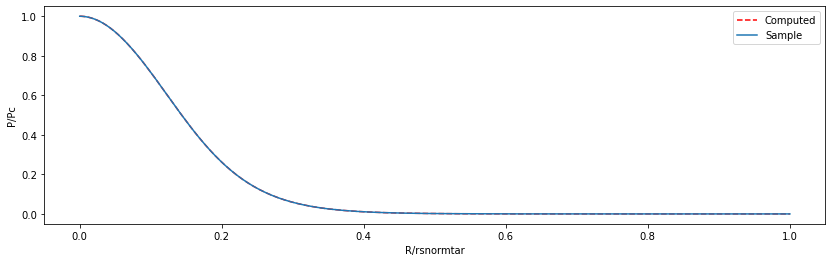

In [417]:
dataset = np.loadtxt("highmass_star.txt")
test = StellarModel(5/3, 0.7, 0.265)

rhos = dataset[:,2]*1000 #unit conversion from g/cm^3 to kg/m^3
Ts = dataset[:,3] #in kelvin
rsnorm = dataset[:,10] #is unitless
Ps = dataset[:, 19]*0.1 #convert from erg/cm^3

Pc = test.P(rhos[0], T[0]) #in Pascales
Pnormed= test.P(rhos, T)/Pc #normalize (to better compare/minimze risk or error)
print("Computed Central Pressure [Pa]: ", Pc)
print('Sample Cental Pressure [Pa]: ', Ps[0])

plt.figure(figsize = (14,4))
plt.plot(rsnorm, Pnormed, 'r--', label = 'Computed')
plt.plot(rsnorm, Ps/Ps[0], label = "Sample")
plt.xlabel('R/rsnormtar')
plt.ylabel('P/Pc')
plt.legend()



Text(0, 0.5, 'dPdT [Pa/K]')

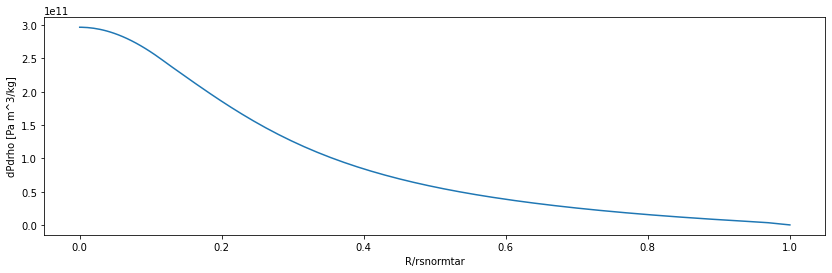

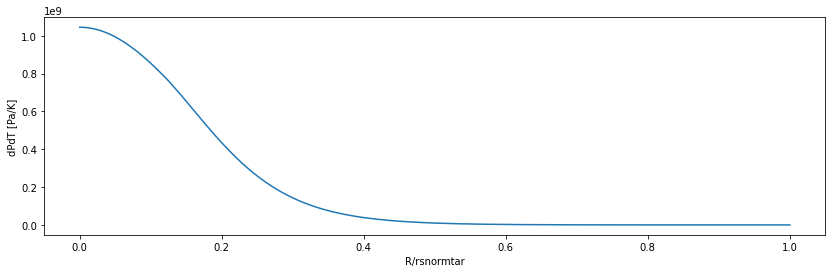

In [418]:
dPdrho = test.dPdrho(rhos,Ts)
dPdT = test.dPdT(rhos,Ts)


plt.figure(figsize = (14,4))
plt.plot(rsnorm, dPdrho)
plt.xlabel('R/rsnormtar')
plt.ylabel('dPdrho [Pa m^3/kg]')


plt.figure(figsize = (14,4))
plt.plot(rsnorm, dPdT)
plt.xlabel('R/rsnormtar')
plt.ylabel('dPdT [Pa/K]')



Computed Kappaes [m^2/kg]:  0.034
Sample Kappaes is [m^2/kg]:  0.034


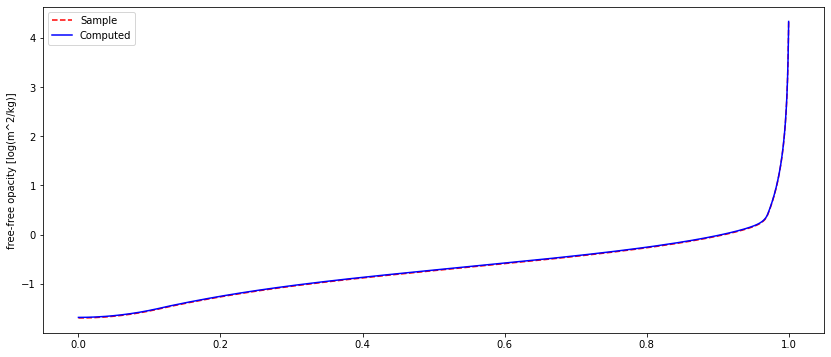

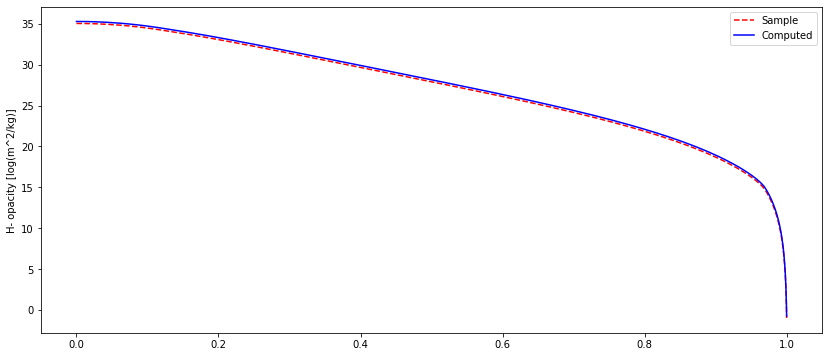

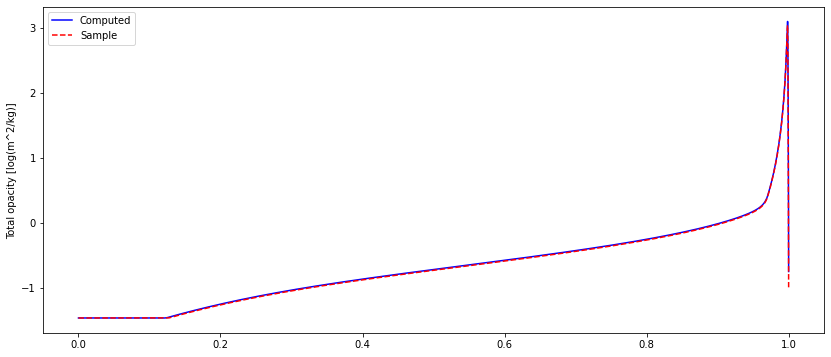

In [419]:
kappaes = test.kappaes
kappaessample = dataset[0,18]*0.1 #convert cm^2/g to m^2/kg
print('Computed Kappaes [m^2/kg]: ', kappaes)
print('Sample Kappaes is [m^2/kg]: ', kappaessample)

kappaffsample = dataset[:, 17]*0.1 #convert cm^2/g to m^2/kg
kappahsample = dataset[:,16]*0.1 #convert cm^2/g to m^2/kg
kappasample = dataset[:, 15]*0.1 #convert cm^2/g to m^2/kg
kappaffcomp = test.kappaff(rhos,Ts)
kappahcomp = test.kappah(rhos, Ts)
kappacomp = test.kappav(rhos,Ts)



plt.figure(figsize = (14,6))
plt.plot(rs, np.log10(kappaffsample), 'r--', label = 'Sample')
plt.plot(rs, np.log10(kappaffcomp), 'b-', label = 'Computed')
plt.ylabel('free-free opacity [log(m^2/kg)]')
plt.legend()

plt.figure(figsize = (14,6))
plt.plot(rs, np.log10(kappahsample), 'r--', label = 'Sample')
plt.plot(rs, np.log10(kappahcomp), 'b-', label = 'Computed')
plt.ylabel('H- opacity [log(m^2/kg)]')
plt.legend()

plt.figure(figsize = (14,6))
plt.plot(rs, np.log10(kappacomp), 'b-', label = 'Computed')
plt.plot(rs, np.log10(kappasample), 'r--', label = 'Sample')
plt.ylabel('Total opacity [log(m^2/kg)]')
plt.legend()


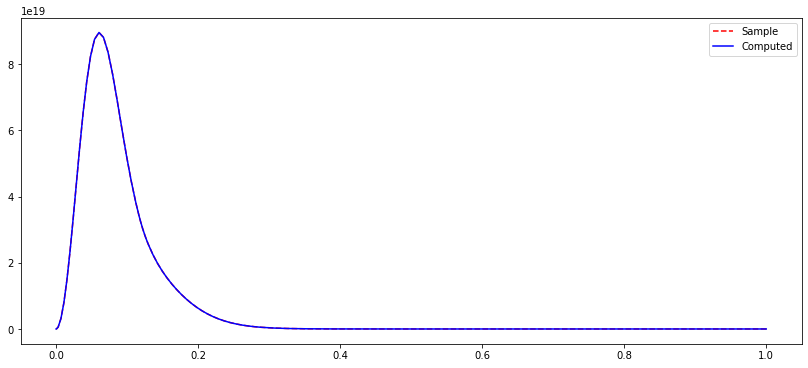

In [420]:
r = dataset[:,1]/100
dLdrsample = dataset[:,6]*1e-5 #convert erg/s/cm to W/m
dLdrcomp = test.dldr(rhos,Ts, r)
plt.figure(figsize =  (14,6))
plt.plot(rs, dLdrsample, 'r--', label = 'Sample')
plt.plot(rs, dLdrcomp, 'b-', label = 'Computed')
plt.legend()

## 2nd Class: Star
This class is essentially the bread and butter of this project. To reiterate, the reason for keeping the classes seperated is to produce more readable code and better allow us to iterate our design choices (which is also the reason I was able to keep working on it after the presentations). I chose to have our solver inherit from our physics class mainly because it made the code more readable and less confusing for those not used to OOP and solving DE's in OOP. 

Star has a few additional parameters that StellarModel doesn't have, namely our bounds to give to the ode solver. The others being the central temperature which is our main sequence parameter (the reason we choose Tc and shoot rhoc is that Tc would be multivalued at the center depending if it is convective or radiative there). The last two are the bounds for our central density range to use in the bisection portion of the shooting method. 

The class also houses a number of methods needed to properly evaluate solutions and have consistent boundary conditions (i.e. have fully converged solutions). The first of these is Star.initial_condition which computes the initial coditions at our starting radii. Then, we also have Star.surface_error which we use in the shooting method to find the proper value of rhoc (i.e. the equation we wish to find the root of). We also have Star.find_surf which allows us to find our surface.

We also create an event which will terminate our integration either when dtau/oppacityproxy is smaller than some tolerence or when the mass enclosed surpasses 10^3 solar masses. We use this using the event system provided by scipy's solve_ivp solver. An event only needs to be defined as a function of the independant variable and the current state of the system (i.e. f(r,y). The event will be recorded when the function returns 0. Hence we use a mix of conditionals to return 1 when neither of our conditions are met and 0 when at least one is met. 

Then we have our solver methods: Star.solve_stellar_eqns which is just a wrapper around scipy's solve_ivp (which we used over ode_int as it allows for a more granular control of the integration process). The specific choises made related to the default ode solver are to use an RK45 (sometimes Runge Kutta Falberg method) with an adaptive step-size. Events are used to stop integration once a large enough radius (or mass) is reached and dense_output is set to true which should allow for better surface interpolation. The reason being that an adaptive step-size might not have sample points near the actual value of the surface radius. The only argument for this method is our initial conditions because we must perform shooting to determine them. Since we are using dense_output and RK45, we will not set a max-step size to allow for better performance since RK45 controls our accuracy/error and selects an appropriate step size each step. Setting a max-step size can come at a great performance cost since we are dealing with many order of magnitude on our integration interval (too small a size would defeat the purpose of using an adaptive step method)

The 2nd solver method is Star.shoot which implements the shooting method with bisection. The shooting method simply iterates solution generated using values of rhoc over some interval and finds the best value according to some conditions (i.e. in our case, we wish to minize surface errors). The purpouse of using bisection is to speed this process up by using the intermediate value theorem to allow us to find the root of our surface error method without checking every value of rhoc on our interval. We bound our parameter on some interval, comput solutions on the bounds and at the midpoint and keep the bound that makes the midpoint respect the IVT so that we can keep itterating. A more thorough explainer of this method can be found in *Computational Physics by Mark Newmann*

Lastly, we provide a simple method to run the shooting method, evaluate the true solution and saving them in our class to be accesses for plotting. 


In [437]:
class Star(StellarModel):
   
    def __init__(self, gamma, Tc, X= 0.7, Y = 0.265, ri = 700, rf = 1e20, rhomin = 1e3, rhomax = 500e3): 
        ###NOTE: unclear what we have to set rf to (can we integrate to Nan?), not sure if it's needed if we set termination conditions with the events
        '''
        Parameters:
            See StellarModel for gamma, X, Y, Z, Tc, h
            h - step size?
            ri - starting radius
            rf - ending radius...still not clear if we need to set it to just something really big or Nan because of events
            Tc - Main Sequence parameter (i.e. the parameter we manually set to construct a MS star) 
            rhomin - minimal value of rhoc to try for shooting method
            rhomax - see rhomin, but minimun for maximum

        Star is a subclass of stellar model. It allows us to keep ou solver code at an abstraction layer above our model. 
        It comes with the numerical facilities to fully solve the stellar equations defined in StellarModel, 
        whereas StellarModel concerns itself witht he physics of this project star concerns itself with providing the 
        solutions for a single star (i.e. solving the StellarModel)

        '''
        StellarModel.__init__(self, gamma, X, Y)
        self.ri, self.rf = ri, rf

        self.rhoc1, self.rhoc2 = rhomin, rhomax

        self.rhoc = 0
        self.Tc = Tc

        # run the shooting algorithm to find the correct rhoc
       
        # use the correct rhoc to produce the final version of the star 
       # self.y0 = self.initial_conditions(self.rhoc)
       # self.solution = self.solve_stellar_eqns(self.y0)

       
        


    def initial_conditions(self, rhoc):
        '''
        This method serves to calculate the initial conditions for a given initial/core radius,
        an initial/core density, and initial/core temperature.

        We need to use this function as setting M(0) = L(0) = 0 will break the equations.
        As well as having r0 = 0 will also break things.

        Parameters:
            r0 - our small but non-zero starting radius
            rhoc - our guess at a core density (this is our shooting method variable)
            Tc - the main sequence parameter
        '''
        # the initial condition equations given by equation (15) of  the project_description document
        M = 4*np.pi/3 * self.ri**3 * rhoc
        L = M * self.epr(rhoc, self.Tc)

        # return vector of the initial conditions
        return np.array([rhoc, self.Tc, M, L, 0]) 
        
    def surface_error(self, r, y):
        '''
        Parameter: r, y

        r - independent variable, radius
        y = state variable, [rho, T, M, L]

        this is the functions which we wish to use to implement the shooting function
        '''
        L = y[3]
        T = y[1]
        R = r

        f_error = (L-4*np.pi*const.sigma*(R**2)*(T**4))/(np.sqrt(4*np.pi*const.sigma*(R**2)*(T**4)*L))

        return f_error

    
    #Functions for events, one for mass limit, one for radius location and one for the opacity proxy. Mass and opacity proxy are termination events (i.e. to stop the solver)
    def stop(self, r, y):
        if self.opacityproxy(r,y) < 0.00001 or y[2]>1e3*1.989e30:
            return 0
        else:
            return 1

    def events(self):
        Star.stop.terminal = True

        stop = self.stop
        return stop




    def find_surf(self, star):
        '''
        Function for idnentifying where the surface is and returns the radius and
        y vector at that location
        '''
        #get tauinf
        taus = star.y[4]
        tau_inf = taus[-1]

        #save solution ovject
        sol = star.sol
        #lambda to use bisection to find the surface radius
        checkradius = lambda R: (tau_inf - sol(R)[4]) - 2/3
        r1 = 0
        r2 = star.t[-1]

        f1 = checkradius(r1)
        f2 = checkradius(r2)

        for k in range(500):
            rmid = (r1+r2)/2
            fmid = checkradius(rmid)

            if f1*fmid > 0: 
                f1, r1 = fmid, rmid 
            else: 
                f2, r2 = fmid, rmid

            if abs(r1-r2) < 0.001:
                break 

        return (r1+r2)*0.5

    #just a wrapper to avoid havinf to rewrite all the same parameters for shooting. 
    def solve_stellar_eqns(self, y0):
        # max_step sets the max stepsize that you allow the algorithm to take when doing adaptive steps
        return ode.solve_ivp(self.stellarequations, (self.ri, self.rf), y0 = y0, method = 'RK45', events = self.events(), dense_output = True)#, events = self.events() )

    def shoot(self, kmax = 500,eps = 1e-3):
        '''
        Parameters: kmax, eps
        kmax - kmax is the max number of iterations we want to attempt for the shooting method
        eps - eps is the error value we use for when to terminate the shooting method (i.e. error value for which we want eq.17)
        '''
        rho = None

        rho1 = self.rhoc1
        rho2 = self.rhoc2

        init1 = self.initial_conditions(rho1)
        init2 = self.initial_conditions(rho2)

        self.rhoc = rho1
        star1 = self.solve_stellar_eqns(init1)


        self.rhoc = rho2
        star2 = self.solve_stellar_eqns(init2)

        

        
        
        # use the radius event radius value to calcualte surface error using eqn (17)
        r1 = self.find_surf(star1)
        r2 = self.find_surf(star2)
        y1 = star1.sol(r1)
        y2 = star2.sol(r2)
        f1 = self.surface_error(r1, y1)
        f2 = self.surface_error(r2, y2)
        #print('f1: ', f1)
        #print('f2: ', f2)


        # bisection algorithm to solve for roots
        for k in range(kmax):    
            #print("====| k = ", k, ' |====')
            rhomid = (rho1 + rho2)/2
            # just printing off the densities so we can monitor as it undergoes the algorithm.
            #print('rhomid: ',rhomid)
            self.rhoc = rhomid
            initmid = self.initial_conditions(rhomid)
            starmid = self.solve_stellar_eqns(initmid)

            # print('R*: ', starmid.t_events[0][0])
            # print('Surface [rho, T, M, L]: ', starmid.y_events[0][0])
            rmid = self.find_surf(starmid)
            ymid = starmid.sol(rmid)
            fmid = self.surface_error(rmid, ymid)
             
            if f1*fmid > 0: 
                f1, rho1 = fmid, rhomid 
            else: 
                f2, rho2 = fmid, rhomid

            #print('f1: ', f1)
            #print('rho1: ', rho1)
            #print('f2: ', f2)
            #print('rho2', rho2)
            
            if abs(rho1-rho2) < eps:
                rho = 0.5*(rho2+rho1)
                break 
        self.rhoc = rho  
        return rho
        
    def solution(self):
        self.shoot()
        self.y0 = self.initial_conditions(self.rhoc)
        self.solved = self.solve_stellar_eqns(self.y0)

        # creating attributes that can be easily accessed
        

        rsurf = self.find_surf(self.solved)
        solsurf = self.solved.sol(rsurf)
        self.Rsurf = rsurf
        self.Rhosurf = solsurf[0]
        self.Tsurf = solsurf[1]
        self.Msurf = solsurf[2]
        self.Lsurf =solsurf[3]

        self.Rs = np.linspace(0,rsurf, 1000)
        self.Rsnormed = self.Rs/rsurf
        self.Rhos = self.solved.sol(self.Rs)[0]
        self.Rhosnormed = self.Rhos/self.Rhos[0]
        self.Ts = self.solved.sol(self.Rs)[1]
        self.Tsnormed = self.Ts/self.Ts[0]
        self.Ms = self.solved.sol(self.Rs)[2]
        self.Msnormed = self.Ms/self.Ms[-1]
        self.Ls = self.solved.sol(self.Rs)[3]
        self.Lsnormed = self.Ls/self.Ls[-1]
        self.Taus = self.solved.sol(self.Rs)[4]
        self.Ps = self.P(self.Rhos, self.Ts)
        self.kappaevaled = self.kappav(self.Rhos,self.Ts)


### Integration Test
We run a short integration test to make sure the parts of our solver work as intented. Minus the runtime warnings, everything seems in order. Our termination mechanism works as intended, however some of our surface values seem to be on the smaller side. But, all our surface values are on the proper order of magnitude which was not necessarilly the case for the other versions of our code.  

We also test the shooting method and compare central density values. As we see, we get very good agreement with the sample data! 

In [422]:
test = Star(5/3, 2e7)
y0 = test.initial_conditions(77.7466e3)
test.rhoc = 77.7466e3
test.solve_stellar_eqns(y0)

<ipython-input-416-5e17fe24ce50>:51: RuntimeWarning: invalid value encountered in double_scalars
  self.kappaff = lambda rho, T : 1e24*(self.Z+0.0001)*pow((rho/1e3),7/10)*pow(T,-7/2)
<ipython-input-416-5e17fe24ce50>:53: RuntimeWarning: invalid value encountered in double_scalars
  self.kappah = lambda rho, T : 2.5e-32*(self.Z*50)*pow((rho/1e3),1/2)*pow(T,9)
<ipython-input-416-5e17fe24ce50>:33: RuntimeWarning: invalid value encountered in double_scalars
  self.P = lambda rho, T : (pow((3*np.pi*np.pi),2/3)/5)*(const.hbar*const.hbar/const.electron_mass)*pow((rho/const.proton_mass),5/3)+rho*(const.k*T/(self.mu*const.proton_mass))+1/3*self.a*pow(T,4)
<ipython-input-416-5e17fe24ce50>:35: RuntimeWarning: invalid value encountered in double_scalars
  self.dPdrho = lambda rho, T : pow((3*np.pi*np.pi),2/3)/3 * (const.hbar**2/(const.proton_mass*const.electron_mass))*pow((rho/const.proton_mass),2/3)+const.k*T/(self.mu*const.proton_mass)


  message: 'A termination event occurred.'
     nfev: 380
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x7f8b82804430>
   status: 1
  success: True
        t: array([7.00000000e+02, 7.00326129e+02, 7.03587418e+02, 7.36200314e+02,
       1.06232927e+03, 4.32361881e+03, 3.69365142e+04, 3.21288774e+05,
       1.36241068e+06, 3.87441829e+06, 8.67976547e+06, 1.66424338e+07,
       2.87352165e+07, 4.64282506e+07, 5.29015935e+07, 5.93749364e+07,
       1.03918449e+08, 1.53929486e+08, 2.22549151e+08, 3.21502703e+08,
       3.41293413e+08, 3.61084123e+08, 3.78567534e+08, 3.96050945e+08,
       4.13389156e+08, 4.30727368e+08, 4.49094204e+08, 4.67461041e+08,
       4.87602028e+08, 5.07743015e+08, 5.30472197e+08, 5.53201379e+08,
       6.83189067e+08, 8.41312928e+08, 1.07522560e+09, 1.43428813e+09,
       2.01211991e+09, 2.89699287e+09, 4.24278597e+09, 6.27968172e+09,
       9.31344128e+09, 1.37223605e+10, 1.99196891e+10, 2.82781201e+10,
       3.90799033

In [423]:
star = test.solve_stellar_eqns(y0)

r = test.find_surf(star)
y = star.sol(r)
rsample = dataset[-1, 1]/100
ysample = [dataset[-1,2],dataset[-1,3],dataset[-1,4],dataset[-1,5]]
print('The computed value for the surface radius is [m]: ', r)
print('Sample data radius [m]: ', rsample)
print('[rho, T, M, L] in SI: ', y)

print(test.shoot())

<ipython-input-416-5e17fe24ce50>:51: RuntimeWarning: invalid value encountered in double_scalars
  self.kappaff = lambda rho, T : 1e24*(self.Z+0.0001)*pow((rho/1e3),7/10)*pow(T,-7/2)
<ipython-input-416-5e17fe24ce50>:53: RuntimeWarning: invalid value encountered in double_scalars
  self.kappah = lambda rho, T : 2.5e-32*(self.Z*50)*pow((rho/1e3),1/2)*pow(T,9)
<ipython-input-416-5e17fe24ce50>:33: RuntimeWarning: invalid value encountered in double_scalars
  self.P = lambda rho, T : (pow((3*np.pi*np.pi),2/3)/5)*(const.hbar*const.hbar/const.electron_mass)*pow((rho/const.proton_mass),5/3)+rho*(const.k*T/(self.mu*const.proton_mass))+1/3*self.a*pow(T,4)
<ipython-input-416-5e17fe24ce50>:35: RuntimeWarning: invalid value encountered in double_scalars
  self.dPdrho = lambda rho, T : pow((3*np.pi*np.pi),2/3)/3 * (const.hbar**2/(const.proton_mass*const.electron_mass))*pow((rho/const.proton_mass),2/3)+const.k*T/(self.mu*const.proton_mass)
<ipython-input-416-5e17fe24ce50>:40: RuntimeWarning: invalid 

The computed value for the surface radius is [m]:  780987162010.5577
Sample data radius [m]:  934201000.0
[rho, T, M, L] in SI:  [3.73452631e-04 7.48250839e+06 2.22403477e+33 7.42126389e+27
 4.28555346e+11]
77786.83992382139


<ipython-input-416-5e17fe24ce50>:51: RuntimeWarning: invalid value encountered in double_scalars
  self.kappaff = lambda rho, T : 1e24*(self.Z+0.0001)*pow((rho/1e3),7/10)*pow(T,-7/2)
<ipython-input-416-5e17fe24ce50>:53: RuntimeWarning: invalid value encountered in double_scalars
  self.kappah = lambda rho, T : 2.5e-32*(self.Z*50)*pow((rho/1e3),1/2)*pow(T,9)
<ipython-input-416-5e17fe24ce50>:33: RuntimeWarning: invalid value encountered in double_scalars
  self.P = lambda rho, T : (pow((3*np.pi*np.pi),2/3)/5)*(const.hbar*const.hbar/const.electron_mass)*pow((rho/const.proton_mass),5/3)+rho*(const.k*T/(self.mu*const.proton_mass))+1/3*self.a*pow(T,4)
<ipython-input-416-5e17fe24ce50>:35: RuntimeWarning: invalid value encountered in double_scalars
  self.dPdrho = lambda rho, T : pow((3*np.pi*np.pi),2/3)/3 * (const.hbar**2/(const.proton_mass*const.electron_mass))*pow((rho/const.proton_mass),2/3)+const.k*T/(self.mu*const.proton_mass)
<ipython-input-416-5e17fe24ce50>:40: RuntimeWarning: invalid 

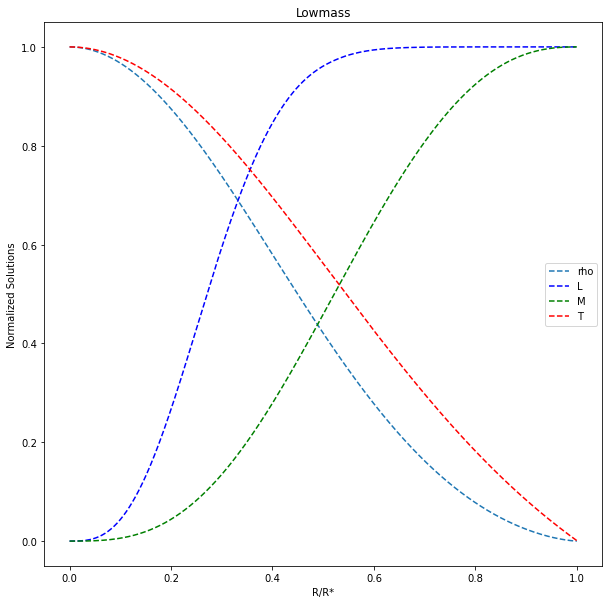

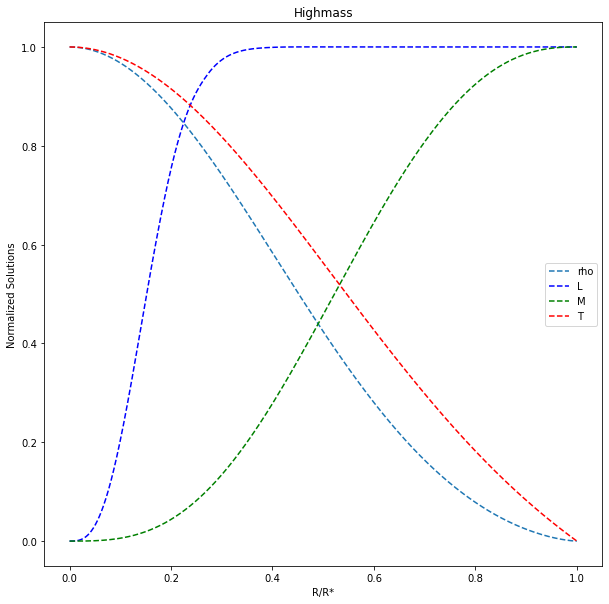

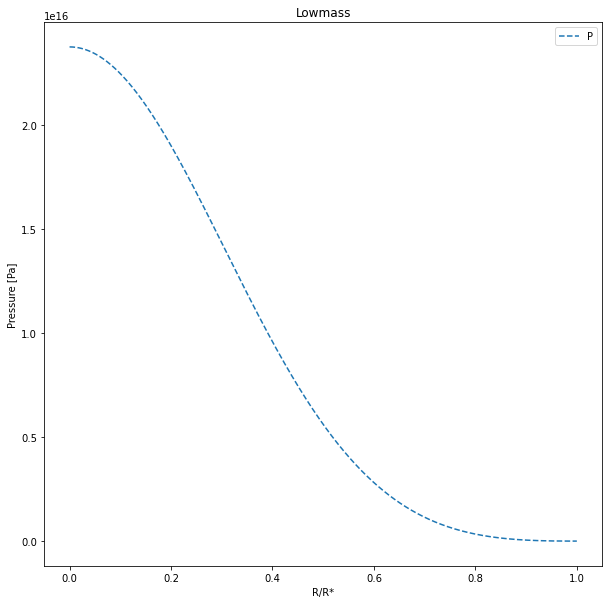

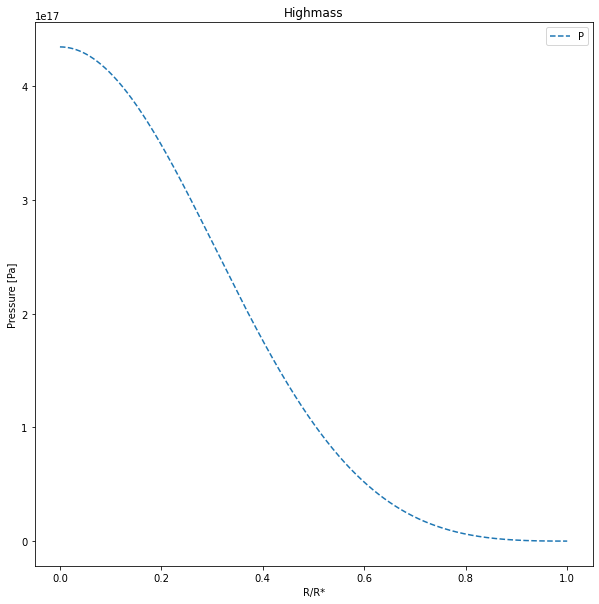

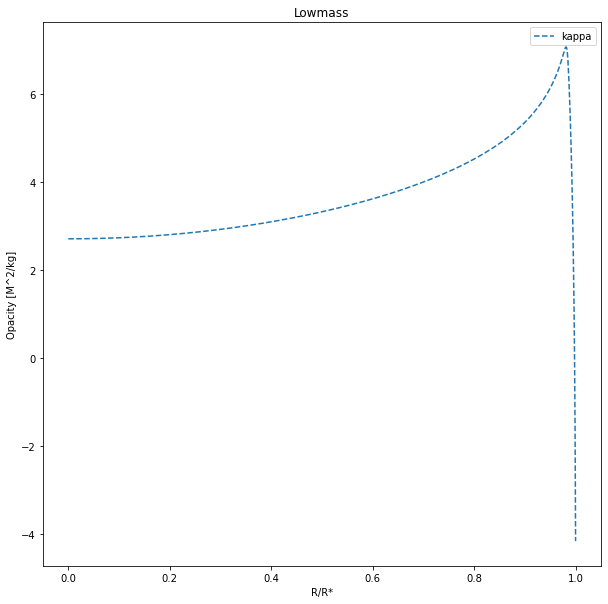

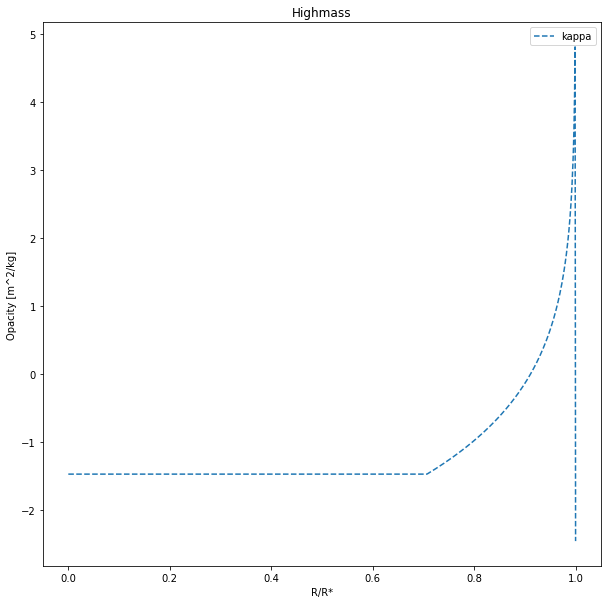

In [446]:
Tcs = [1.5e6, 6e7]
lowmass = Star(5/3, Tcs[0])
highmass = Star(5/3, Tcs[1])

lowmass.solution()
highmass.solution()

plt.figure(figsize = (10,10))
plt.plot(lowmass.Rsnormed, lowmass.Rhosnormed, '--',label = 'rho')
plt.plot(lowmass.Rsnormed, lowmass.Lsnormed, 'b--', label = 'L')
plt.plot(lowmass.Rsnormed, lowmass.Msnormed, 'g--',label = 'M')
plt.plot(lowmass.Rsnormed, lowmass.Tsnormed, 'r--',label = 'T')
plt.xlabel('R/R*')
plt.ylabel('Normalized Solutions')
plt.title("Lowmass")
plt.legend()

plt.figure(figsize = (10,10))
plt.plot(highmass.Rsnormed, highmass.Rhosnormed, '--', label = 'rho')
plt.plot(highmass.Rsnormed, highmass.Lsnormed, 'b--', label = 'L')
plt.plot(highmass.Rsnormed, highmass.Msnormed, 'g--', label = 'M')
plt.plot(highmass.Rsnormed, highmass.Tsnormed, 'r--', label = 'T')
plt.xlabel('R/R*')
plt.ylabel('Normalized Solutions')
plt.title("Highmass")
plt.legend()

lowmassP = lowmass.Ps
highmassP = highmass.Ps

plt.figure(figsize = (10,10))
plt.plot(lowmass.Rsnormed,lowmassP, '--', label = 'P')
plt.xlabel('R/R*')
plt.ylabel('Pressure [Pa]')
plt.title("Lowmass")
plt.legend()

plt.figure(figsize = (10,10))
plt.plot(highmass.Rsnormed,highmassP, '--', label = 'P')
plt.xlabel('R/R*')
plt.ylabel('Pressure [Pa]')
plt.title("Highmass")
plt.legend()

lowmasskappa = lowmass.kappaevaled
highmasskappa = highmass.kappaevaled

plt.figure(figsize = (10,10))
plt.plot(lowmass.Rsnormed,np.log10(lowmasskappa), '--', label = 'kappa')
plt.xlabel('R/R*')
plt.ylabel('Opacity [M^2/kg]')
plt.title("Lowmass")
plt.legend()

plt.figure(figsize = (10,10))
plt.plot(highmass.Rsnormed,np.log10(highmasskappa), '--', label = 'kappa')
plt.xlabel('R/R*')
plt.ylabel('Opacity [m^2/kg]')
plt.title("Highmass")
plt.legend()






